# Random Forest Regression

Random Forest is an ensemble learning method that can be used for both classification and regression tasks. It builds multiple decision trees during training and merges them together to get more accurate and stable predictions. Random Forest adds an extra layer of randomness to bagging; not only are the training sets built by randomly sampling the original dataset, but a subset of features are also selected randomly, making each tree in the forest somewhat different.

Why Random Forest for Regression?
1. **High Accuracy**: Combining predictions from multiple trees improves performance and can help to avoid overfitting.
2. **Feature Importance**: Random Forest provides insights into the importance of each feature in making predictions.
3. **Robustness**: Can handle missing values and outliers well.
4. **Scalability**: Efficient algorithms make it fast, even for large datasets.

### Theoretical Background
A Random Forest consists of \\( N \\) decision trees, \\( T_1, T_2, \ldots, T_N \\). Each tree \\( T_i \\) is trained on a random subset of the data \\( D_i \\), sampled with replacement from the original dataset \\( D \\). For regression tasks, the average output of all trees is considered as the final prediction.

The prediction \\( \hat{y} \\) for a given input \\( x \\) is:

$$ \hat{y} = \frac{1}{N} \sum_{i=1}^{N} T_i(x) $$

The optimization typically involves minimizing a loss function. For regression tasks, the most commonly used loss function is the Mean Squared Error (MSE):

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

where \\( y_i \\) is the actual value and \\( \hat{y}_i \\) is the predicted value for the \\( i^{th} \\) observation.

#### Tuning Parameters
* **Number of Trees \\( N \\)**
* **Maximum Depth of Trees**
* **Minimum Samples to Split**
* **Minimum Samples per Leaf**

#### Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Display the first few rows of each DataFrame as scrollable tables in Jupyter Notebook
from IPython.display import display, HTML

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

#### Custom Functions

In [2]:
# Custom prediction function
def custom_predict(X, model):
    y_pred = model.predict(X)
    
    # Apply the flagged logic
    y_custom_pred = np.where(X['flagged'] == 1, 0, y_pred)
    
    return y_custom_pred

# Calculate performance metrics function
def metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f" MSE = {mse}\nRMSE = {rmse}\n MAE = {mae}\n  r2 = {r2}")

#### Load data

In [3]:
# Load the electricity consumption dataset
filepath = 'C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Forecasting-energy-consumption-in-Denmark/Data/Combined data/'
data_flagged = pd.read_csv(filepath + 'combined_daily_flagged.csv')

# Put HourDK as DataFrame index
data_flagged.set_index('HourDK', inplace=True)

In OLS we found that the Flagging method worked best when predicting using methods whith coeffictions, this idea would be the same with Random Forrest Regression, therefor we will focus on this method when using Random Forrest Regression.

#### Split into test and Training

In [4]:
# Re-split the data into training and test sets based on the criteria
training_set = data_flagged.loc[data_flagged.index <= '2022-06-30']
test_set = data_flagged.loc[data_flagged.index > '2022-06-30']

Split our Data into X and Y, with other words our feature variables, X, and our target variable, Y. We want to predict Y using information from X.

In [5]:
# Define features and target variable for training set
X_train = training_set.drop(['GrossConsumptionMWh'], axis=1)
y_train = training_set['GrossConsumptionMWh']

# Define features for test set
X_test = test_set.drop(['GrossConsumptionMWh'], axis=1)
y_test = test_set['GrossConsumptionMWh']

#### Fitting data to our Random Forrest Regression model

In [6]:
# Initialize and train a Random Forest model with a different random seed
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = custom_predict(X_test, rf_regressor)

#### Metrics:

In [7]:
metrics(y_test,y_pred)

 MSE = 24441193.72529574
RMSE = 4943.8035686398125
 MAE = 3879.0481242381516
  r2 = 0.8793678790967633


#### Plot the results

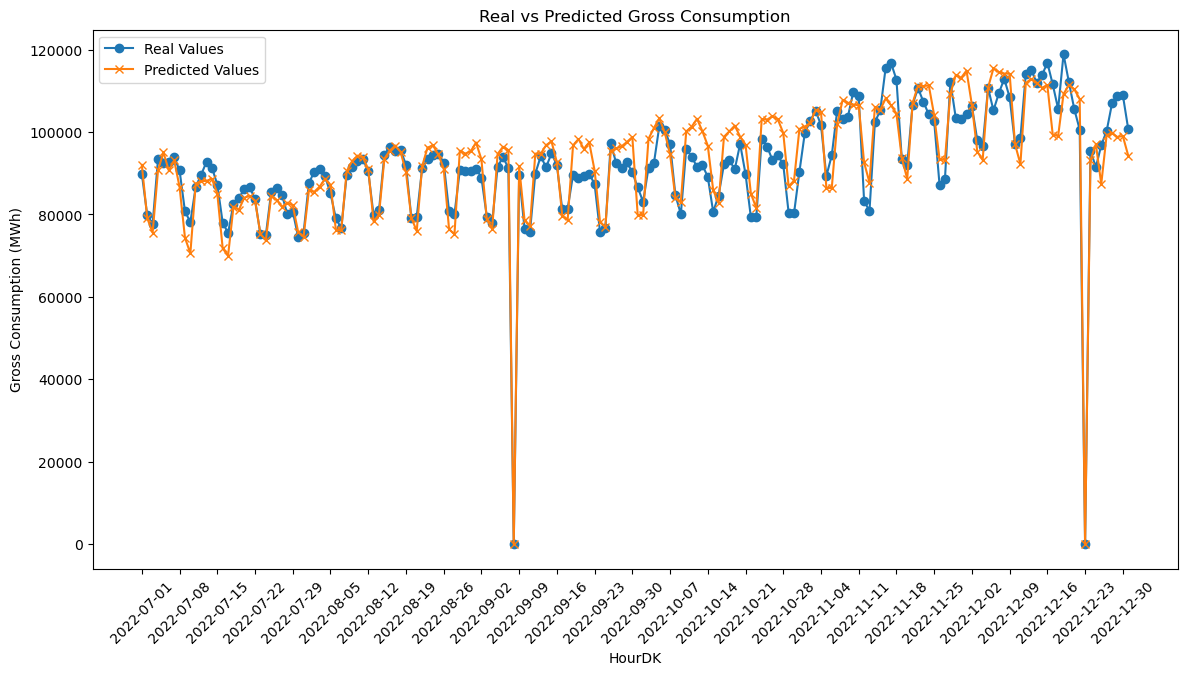

In [8]:
# Plotting the real and predicted values for better visualization
plt.figure(figsize=(14, 7))                                    # Setting Plot size

plt.plot(np.array(y_test), label='Real Values', marker='o')    # Plotting the real values
plt.plot(y_pred, label='Predicted Values', marker='x')         # Plotting the predicted value

plt.xlabel('HourDK')                                           # Adding labels
plt.ylabel('Gross Consumption (MWh)')                          # Adding labels
plt.title('Real vs Predicted Gross Consumption')               # Adding title
plt.legend()                                                   # Adding legend
plt.xticks(rotation=45)                                        # Rotating x-axis labels for better readability
plt.xticks(np.arange(0, len(X_test), 7), X_test.index[::7])    # Show only every 7th date

plt.show()

#### Hyper Optimazation

In [9]:
# Define the hyperparameters and their possible values
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [None,1, 2, 4],
    'min_samples_split': [30, 40, 50],
    'n_estimators': [70, 80, 90],
}

# Create the grid search with 3-fold cross validation
rf_grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
                              cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = rf_grid_search.best_params_
best_params

Fitting 3 folds for each of 144 candidates, totalling 432 fits


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 40,
 'n_estimators': 80}

#### Fitting data to the Hyper parameter optimized model

In [10]:
# Initialize and train a Random Forest model with the best parameters
rf_optimized = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
rf_optimized.fit(X_train, y_train)

# Make predictions on the test set using the custom prediction function
y_pred_optimized = custom_predict(X_test, rf_optimized)

#### Comparing Metrics

In [11]:
print("Before Hyperparameter optimazation:")
metrics(y_test, y_pred)

print("\nAfter Hyperparameter optimazation:")
metrics(y_test, y_pred_optimized)

Before Hyperparameter optimazation:
 MSE = 24441193.72529574
RMSE = 4943.8035686398125
 MAE = 3879.0481242381516
  r2 = 0.8793678790967633

After Hyperparameter optimazation:
 MSE = 20954772.05253128
RMSE = 4577.638261432557
 MAE = 3614.3962354249165
  r2 = 0.896575485463113


#### Zoomed-in plot of predictions after optimization

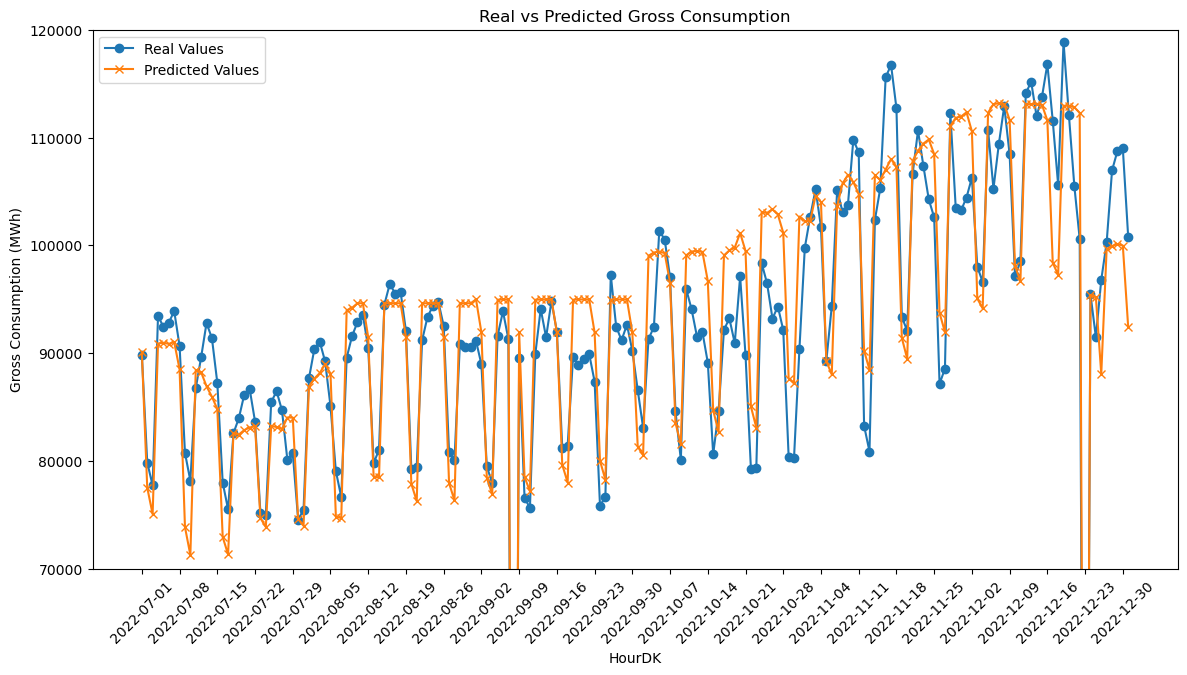

In [12]:
# Plotting the real and predicted values for better visualization
plt.figure(figsize=(14, 7))                                    # Setting Plot size

plt.plot(np.array(y_test), label='Real Values', marker='o')    # Plotting the real values
plt.plot(y_pred_optimized, label='Predicted Values', marker='x')         # Plotting the predicted value

plt.xlabel('HourDK')                                           # Adding labels
plt.ylabel('Gross Consumption (MWh)')                          # Adding labels
plt.title('Real vs Predicted Gross Consumption')               # Adding title
plt.legend()                                                   # Adding legend
plt.xticks(rotation=45)                                        # Rotating x-axis labels for better readability
plt.xticks(np.arange(0, len(X_test), 7), X_test.index[::7])    # Show only every 7th date
plt.ylim(70000, 120000)                                        # Set y-axis limits

plt.show()

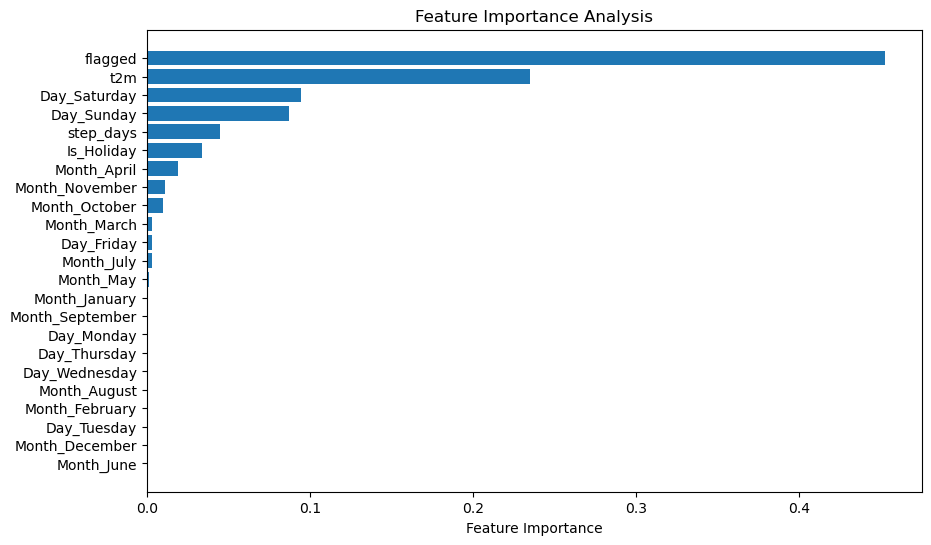

,Feature,Importance
0,flagged,0.452657
1,t2m,0.235007
9,Day_Saturday,0.094327
10,Day_Sunday,0.087352
2,step_days,0.044898
3,Is_Holiday,0.033441
14,Month_April,0.018769
21,Month_November,0.011178
20,Month_October,0.009883
13,Month_March,0.003375


In [13]:
# Get feature importances from the optimized Random Forest model
feature_importances = rf_optimized.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Sort the features by importance
sorted_idx = np.argsort(feature_importances)

# Create a horizontal bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by the importances
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

display(feature_importance_df)

### Feature Importance Analysis: Random Forest vs OLS Coefficients
When examining the feature importances from the Random Forest Regression (RFR) and the coefficients from the Ordinary Least Squares (OLS) model, some intriguing similarities and differences emerge.

#### Interpretation:
1. `Flagged`:
    * RFR: The 'flagged' feature has the highest importance score at 0.453.
    * OLS: The coefficient for the 'flagged' variable is -93,662.
    * Analysis: Both models identify the 'flagged' feature as highly significant. While RFR ranks it as the most important      feature, OLS suggests a strong negative adjustment for missing data, predicting a sharp decline in gross consumption        when the data is flagged as missing.
2. `Temperature (t2m)`:
    * RFR: Importance score of 0.235.
    * OLS: Coefficient of -677.65.
    * Analysis: RFR ranks temperature as the second most important feature, whereas in OLS, the coefficient is negative but       of smaller magnitude, suggesting lesser importance.
3. `Is_Holiday`:
    * RFR: Importance score of 0.033.
    * OLS: Coefficient of -12,752.
    * Analysis: Both models find holidays to be significant but to different extents. RFR assigns a moderate importance, whereas OLS suggests a more pronounced effect on reducing electricity consumption.
4. `Days of the Week`:
    * RFR: Day_Saturday and Day_Sunday have importance scores of 0.094 and 0.087, respectively.
    * OLS: Coefficients are -10,006 and -11,073, respectively.
    * Analysis: Both models consistently indicate that weekends usually see less electricity consumption compared to other       days, although RFR ranks them higher in importance.
5. `Months`:
    * RFR: Months like Month_April and Month_November have lower importance scores.
    * OLS: Coefficients for months vary but are generally smaller in magnitude.
    * Analysis: Both models suggest that months have some impact, but the influence is less consistent and not the primary       driver for changes in electricity consumption.
####  Comparisons:
The `flagged` variable is a significant addition in both models, but its high negative value in OLS is particularly noteworthy.
RFR gives higher importance to `temperature`, whereas OLS suggests its impact is minimal.
`Holidays` and weekends are consistently significant in both models, although the magnitude of their importance varies.
##### Summary:
The feature importances from the Random Forest model and the coefficients from the OLS model provide complementary insights into electricity consumption patterns. While both models agree on the importance of flagged data, holidays, and weekdays, they differ in the significance attributed to temperature. Random Forest offers a more nuanced understanding by ranking features based on their ability to decrease impurity, thus making it a comprehensive model for understanding energy consumption patterns.

By comparing the two, we can better understand the robustness and sensitivities of our predictive models, helping to guide future feature selection and engineering efforts.

###### metrics:
**Ordinary Least Square model**:
$$\begin{align*}
\text{MSE}  &= 22,500,416.75 \\
\text{RMSE} &= 4743.46 \\
\text{MAE}  &= 3804.09 \\
R^2         &= 0.889
\end{align*}$$

**Random Forrest Regression model**:
$$\begin{align*}
\text{MSE}  &= 20,954,772.05\\
\text{RMSE} &= 4577.64 \\
\text{MAE}  &= 3614.40 \\
R^2         &= 0.897
\end{align*}$$

In the task of predicting energy consumption, Random Forest Regression (RFR) consistently outperforms the Ordinary Least Squares (OLS) method across key evaluation metrics. Specifically, RFR exhibits lower values for both Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), signifying more accurate predictions with smaller errors. Additionally, the model's Mean Absolute Error (MAE) is lower, further suggesting that its predictions are, on average, closer to the actual observations. The Coefficient of Determination (\\(R^2 \\)) is also marginally higher for RFR, indicating a slightly better explanation of the variability in the dataset. Taking all these factors into account, while both models offer strong predictive capabilities, RFR proves to be more accurate and reliable for this specific application. Therefore, Random Forest Regression stands out as the more suitable model for predicting energy consumption in this context.